In [1]:
import sys
sys.path.append('../utils/')

import layoutparser as lp
from pdftools import *
import numpy as np 

## Load the PDF tokens and images 

In [2]:
! mkdir data; curl https://arxiv.org/pdf/2006.01038.pdf --output data/2006.01038.pdf

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4752k  100 4752k    0     0  3157k      0  0:00:01  0:00:01 --:--:-- 3155k


In [3]:
pdf_filename = 'data/2006.01038.pdf'
page_images, page_layouts = load_PDF_tokens_with_images(pdf_filename)

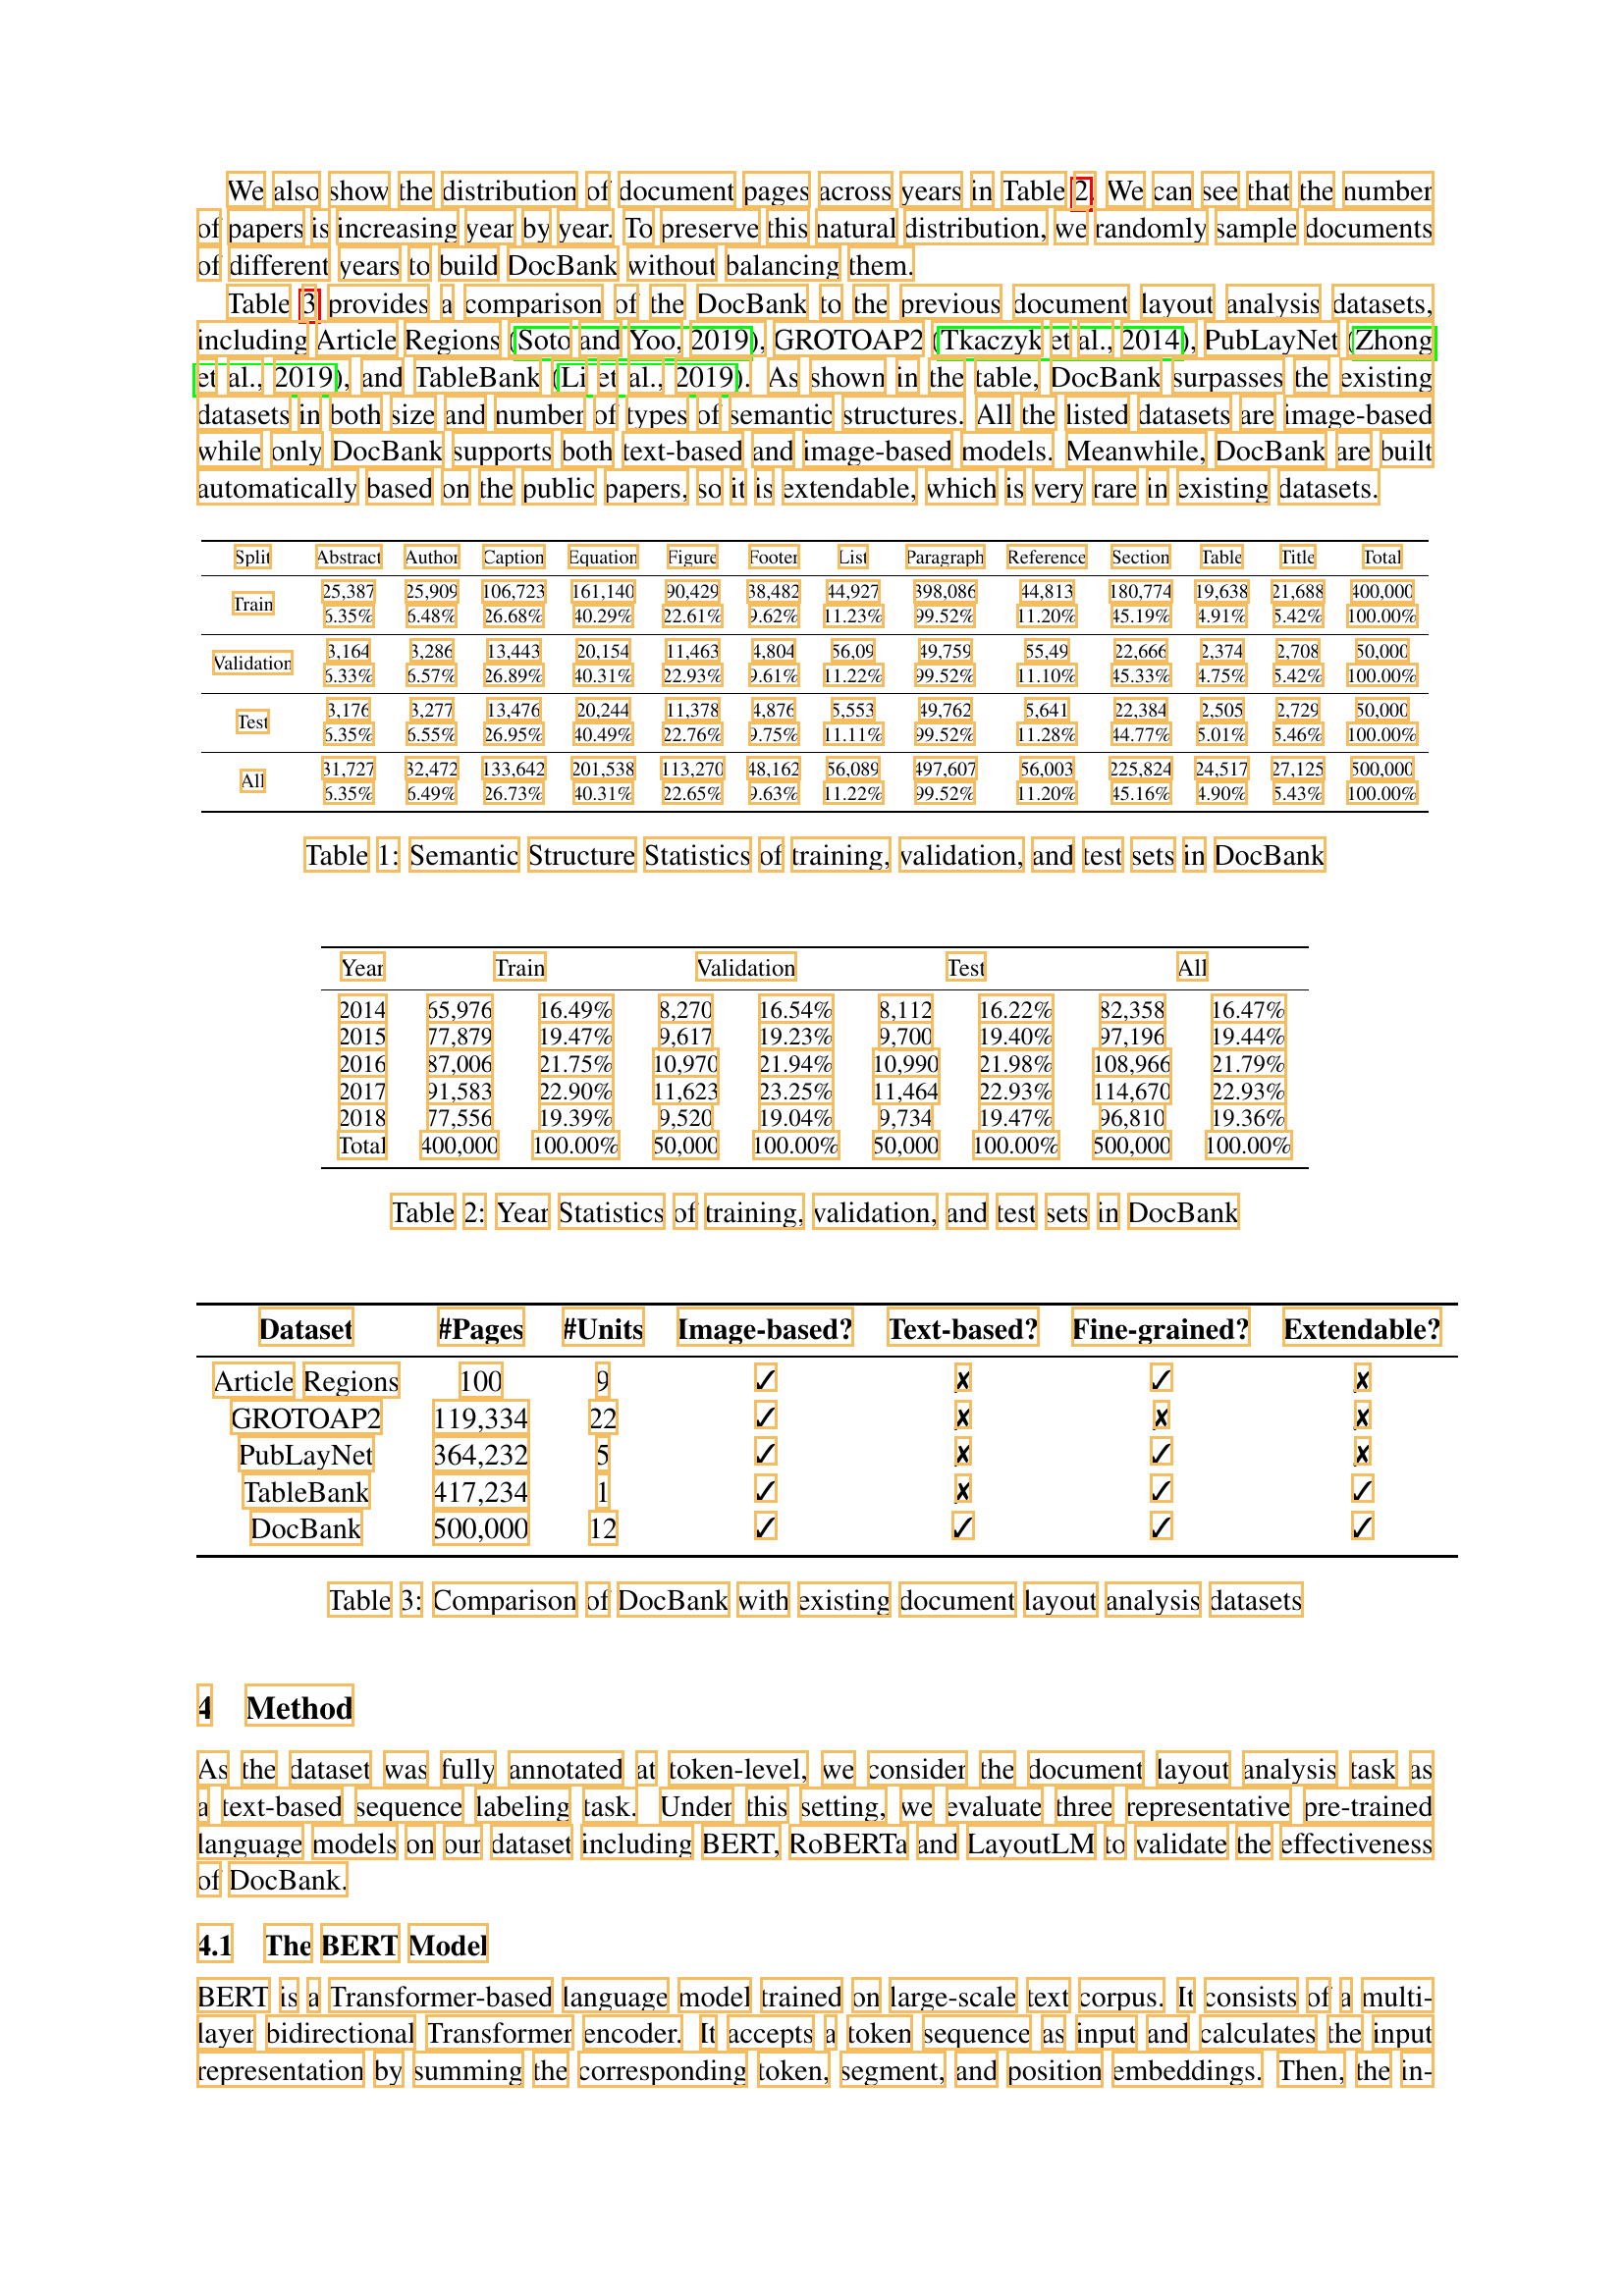

In [4]:
lp.draw_box(page_images[4].copy(), page_layouts[4], box_width=3)

## Download the model and run predictions 

Use gdown to donload the models: 

```bash
pip install gdown
```

```
mkdir -p models/mask_rcnn_R_50_FPN_3x; cd models/mask_rcnn_R_50_FPN_3x
gdown "https://drive.google.com/uc?id=1MbjMXgkIkXLY8f0fFgvqf_RHKIKCClgf" # Config file
gdown "https://drive.google.com/uc?id=1HNNQpc6gOF_92vDAlpDcTTPQQxYQXTga" # Model file
```

In [5]:
model = lp.Detectron2LayoutModel(config_path ='models/publaynet/mask_rcnn_R_50_FPN_3x/config.yaml',
                                 model_path  ='models/publaynet/mask_rcnn_R_50_FPN_3x/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.6, 
                                               "MODEL.ROI_HEADS.NMS_THRESH_TEST", 0.2],
                                 label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [6]:
color_map = {
    "Text":  "red",
    "Title": "green",
    "List":  "blue",
    "Table": "purple",
    "Figure": "yellow",
}

In [7]:
page_id = 4

pred_layout = model.detect(np.array(page_images[page_id]))
pred_layout = [b.set(id=f'{b.type}/{b.score:.2f}') for b in pred_layout]

/Users/shannons/miniconda3/lib/python3.8/site-packages/detectron2/layers/wrappers.py:125: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


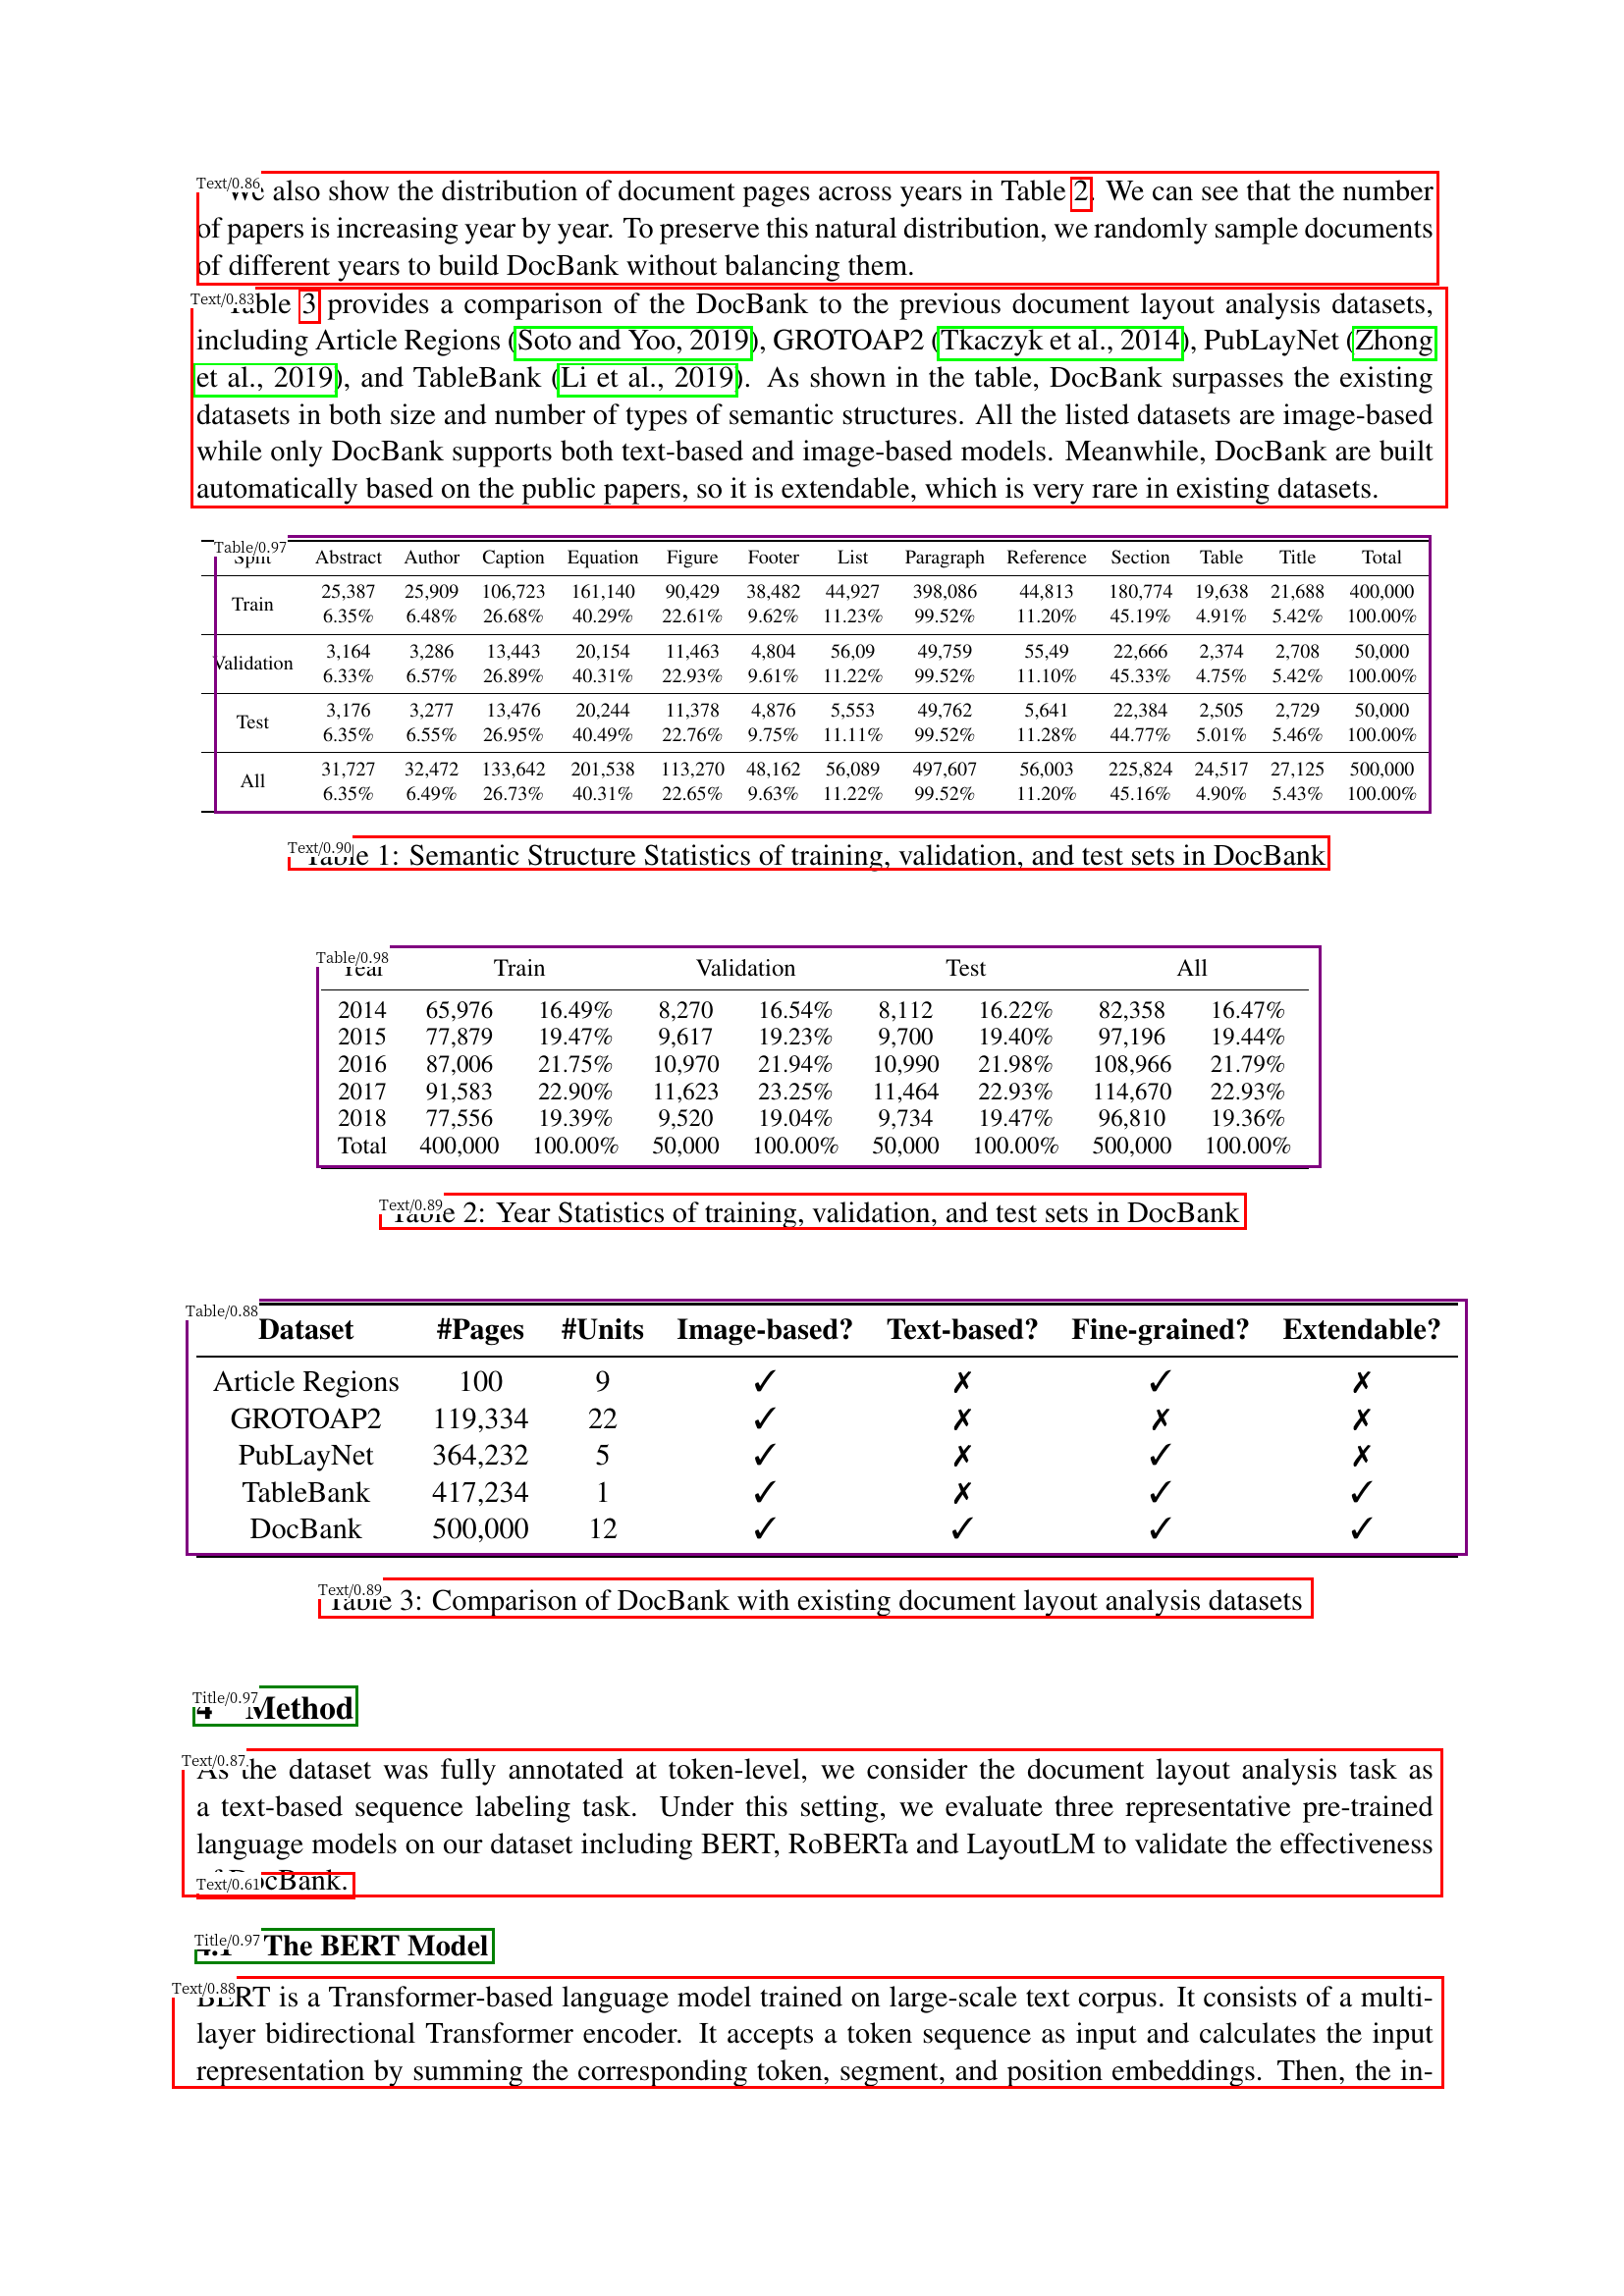

In [8]:
lp.draw_box(page_images[page_id].copy(), pred_layout, color_map=color_map, box_width=3, show_element_id=True)

In [9]:
cur_paper_image = page_images[page_id]
cur_paper_layout = page_layouts[page_id]

In [10]:
changed_layout = []

for block in sorted(pred_layout, key=lambda x: x.block.y_1):
    changed_layout.extend([b.set(type=block.type) for b in cur_paper_layout.filter_by(block, center=True)])

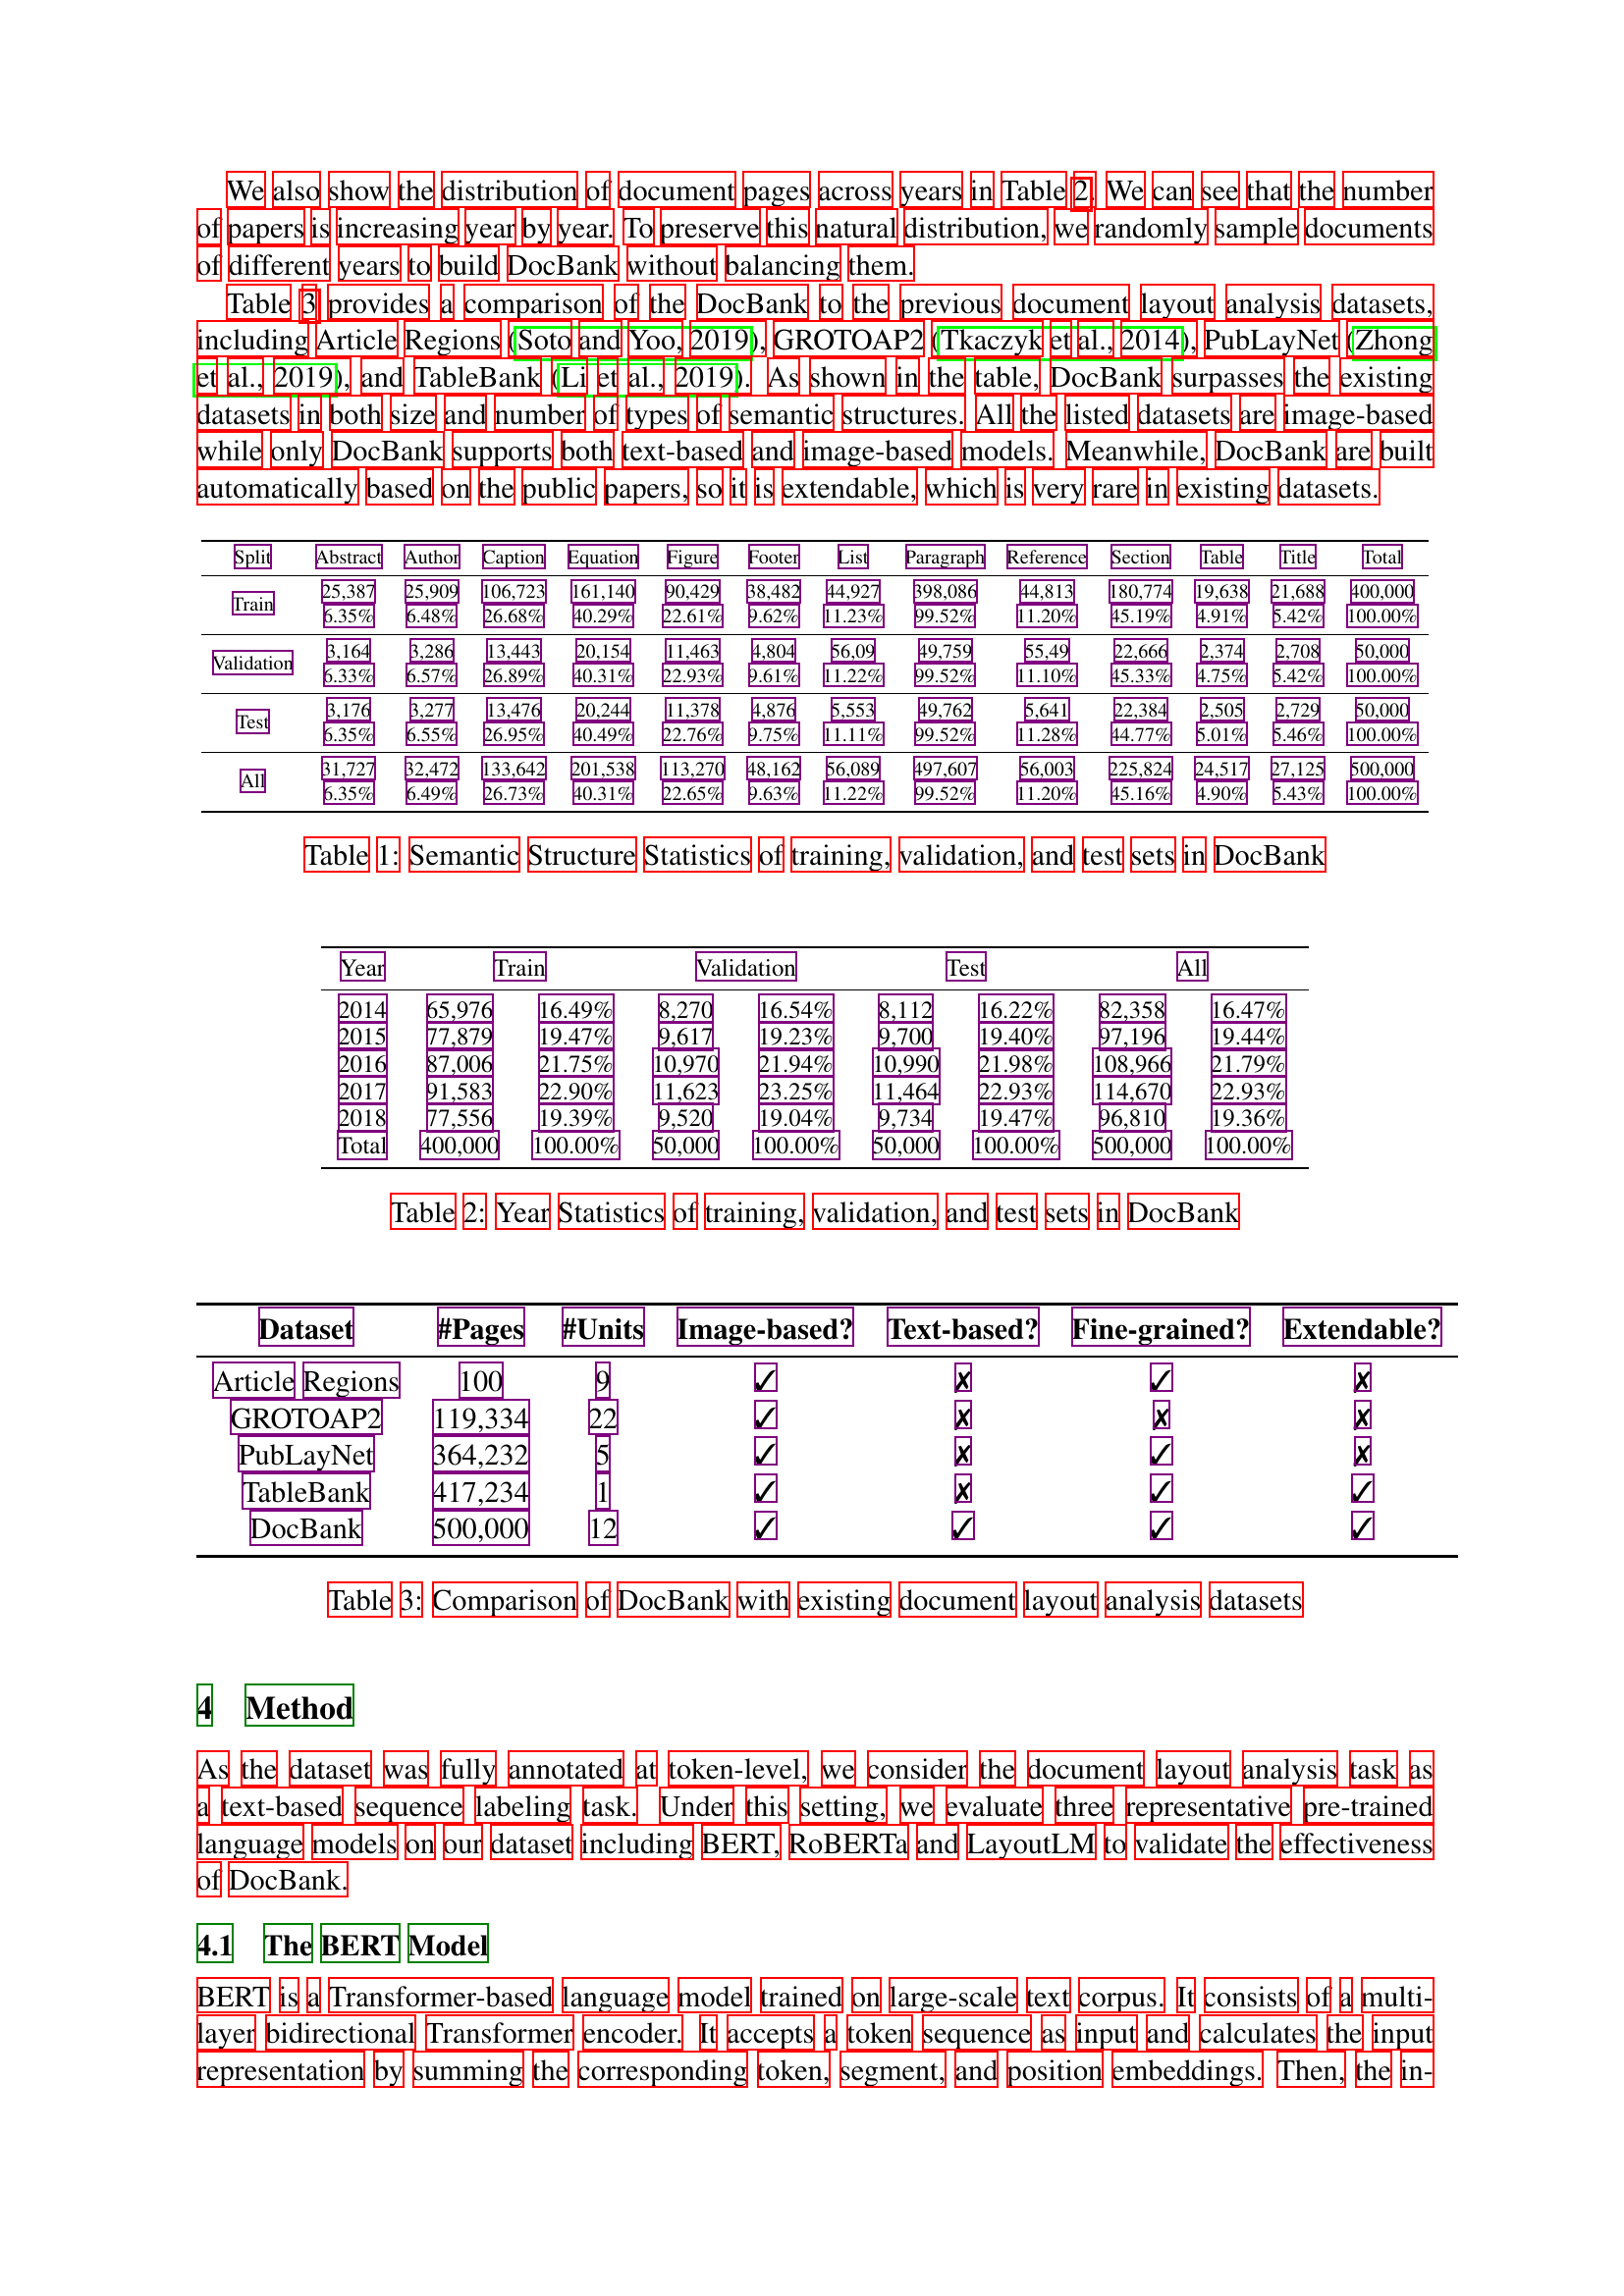

In [11]:
lp.draw_box(cur_paper_image.copy(), changed_layout, color_map=color_map, box_width=2)